In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import math
import numpy as np
import pandas as pd
import numba as nb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("error")


def train_update_test_split_by_user(X: pd.DataFrame, frac_test_users: float):
    users = X["user_id"].unique()

    # Data for the users that won't be included in the training
    test_users = np.random.choice(
        users, size=round(frac_test_users * len(users)), replace=False
    )

    # Training matrix
    train_data = X.query("user_id not in @test_users").sample(
        frac=1, replace=False
    )

    # Train and test sets for updating the model. 
    # For each user split their ratings into two sets, half for update and half for test
    non_train_data = X.query("user_id in @test_users")
    update_data, test_data = train_test_split(
        non_train_data, stratify=non_train_data["user_id"], test_size=0.5
    )

    return (train_data, update_data, test_data)

@nb.njit()
def _sgd(
    X: np.ndarray,
    global_mean: float,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    user_features: np.ndarray,
    item_features: np.ndarray,
    n_epochs: int,
    lr: float,
    reg_param: float,
    min_rating: float,
    max_rating: float,
    logging: bool
):
    train_rmse = []

    for epoch in range(n_epochs):
        # Shuffle dataset before each epoch
        np.random.shuffle(X)

        # Iterate through all ratings and update the model
        for i in range(X.shape[0]):
            user_id, item_id, rating = int(X[i, 0]), int(X[i, 1]), X[i, 2]

            _sgd_update(
                user_id=user_id,
                item_id=item_id,
                rating=rating,
                global_mean=global_mean,
                user_biases=user_biases,
                item_biases=item_biases,
                user_features=user_features,
                item_features=item_features,
                lr=lr,
                reg_param=reg_param
            )

        # Calculate error and print
        rmse = _calculate_rmse(
            X=X,
            global_mean=global_mean,
            user_biases=user_biases,
            item_biases=item_biases,
            user_features=user_features,
            item_features=item_features,
            min_rating=min_rating,
            max_rating=max_rating
        )
        train_rmse.append(rmse)

        if logging:
            print("Epoch ", epoch + 1, "/", n_epochs, " -  train_rmse:", rmse)

    return user_features, item_features, user_biases, item_biases, train_rmse

@nb.njit()
def _sgd_update(
    user_id: int,
    item_id: int,
    rating: float,
    global_mean: float,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    user_features: np.ndarray,
    item_features: np.ndarray,
    lr: float,
    reg_param: float
):
    n_factors = user_features.shape[1]
    user_bias = user_biases[user_id]
    item_bias = item_biases[item_id]

    # Compute predicted rating
    rating_pred = _kernel_linear(
        global_mean,
        user_bias,
        item_bias,
        user_features[user_id, :], 
        item_features[item_id, :]
    )

    # Compute error
    error = rating_pred - rating

    # Update bias parameters
    user_biases[user_id] -= lr * (error + reg_param * user_bias)
    item_biases[item_id] -= lr * (error + reg_param * item_bias)

    # Update user and item features
    for f in range(n_factors):
        user_feature_f = user_features[user_id, f]
        item_feature_f = item_features[item_id, f]

        user_features[user_id, f] -= lr * (error * item_feature_f + reg_param * user_feature_f)
        item_features[item_id, f] -= lr * (error * user_feature_f + reg_param * item_feature_f)

    return

@nb.njit()
def _kernel_linear(
    global_mean: float,
    user_bias: float,
    item_bias: float,
    user_feature_vec: np.ndarray,
    item_feature_vec: np.ndarray,
):
    result = global_mean + item_bias + user_bias + np.dot(user_feature_vec, item_feature_vec)
    return result

@nb.njit()
def _predict(
    X: np.ndarray,
    global_mean: float,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    user_features: np.ndarray,
    item_features: np.ndarray,
    min_rating: int,
    max_rating: int,
    bound_ratings: bool
):
    n_factors = user_features.shape[1]
    predictions = []

    for i in range(X.shape[0]):
        user_id, item_id = int(X[i, 0]), int(X[i, 1])
        user_known = user_id != -1
        item_known = item_id != -1

        # Default values if user or item are not known
        user_bias = user_biases[user_id] if user_known else 0
        item_bias = item_biases[item_id] if item_known else 0
        user_feature_vec = (
            user_features[user_id, :] if user_known else np.zeros(n_factors)
        )
        item_feature_vec = (
            item_features[item_id, :] if item_known else np.zeros(n_factors)
        )

        # Calculate predicted rating
        rating_pred = _kernel_linear(
            global_mean=global_mean,
            user_bias=user_bias,
            item_bias=item_bias,
            user_feature_vec=user_feature_vec,
            item_feature_vec=item_feature_vec,
        )

        # Bound ratings to min and max rating range
        if bound_ratings:
            if rating_pred > max_rating:
                rating_pred = max_rating
            elif rating_pred < min_rating:
                rating_pred = min_rating

        predictions.append(rating_pred)

    return predictions
    
@nb.njit()
def _calculate_rmse(
    X: np.ndarray,
    global_mean: float,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    user_features: np.ndarray,
    item_features: np.ndarray,
    min_rating: float,
    max_rating: float
):
    n_ratings = X.shape[0]
    errors = np.zeros(n_ratings)

    # Iterate through all ratings and calculate error
    for i in range(n_ratings):
        user_id, item_id, rating = int(X[i, 0]), int(X[i, 1]), X[i, 2]
        user_bias = user_biases[user_id]
        item_bias = item_biases[item_id]
        user_feature_vec = user_features[user_id, :]
        item_feature_vec = item_features[item_id, :]

        # Calculate predicted rating
        rating_pred = _kernel_linear(
            global_mean=global_mean,
            user_bias=user_bias,
            item_bias=item_bias,
            user_feature_vec=user_feature_vec,
            item_feature_vec=item_feature_vec
        )

        # Calculate error
        errors[i] = rating - rating_pred

    rmse = np.sqrt(np.square(errors).mean())
    return rmse

In [3]:
class MF():

    def __init__(
        self,
        n_factors: int,
        train_epochs: int,
        update_epochs: int,
        reg_param: float,
        train_lr: float,
        update_lr: float,
        init_mean: float,
        init_sd: float,
        min_rating: int,
        max_rating: int,
        bound_ratings: bool,
        logging: bool
    ):
        self.n_factors = n_factors
        self.train_epochs = train_epochs
        self.update_epochs = update_epochs
        self.reg_param = reg_param
        self.train_lr = train_lr
        self.update_lr = update_lr
        self.init_mean = init_mean
        self.init_sd = init_sd
        self.min_rating = min_rating
        self.max_rating = max_rating
        self.bound_ratings = bound_ratings
        self.logging = logging

    def fit(self, X: pd.DataFrame):
        X = self.preprocess_data(X, type="fit")
        self.global_mean = X["rating"].mean()

        # Initialize vector bias parameters
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)

        # Initialize matrices P and Q
        self.user_features = np.random.normal(
            self.init_mean, self.init_sd, (self.n_users, self.n_factors)
        )
        self.item_features = np.random.normal(
            self.init_mean, self.init_sd, (self.n_items, self.n_factors)
        )

        # Perform stochastic gradient descent
        (
            self.user_features,
            self.item_features,
            self.user_biases,
            self.item_biases,
            self.train_rmse
        ) = _sgd(
            X=X.to_numpy(),
            global_mean=self.global_mean,
            user_biases=self.user_biases,
            item_biases=self.item_biases,
            user_features=self.user_features,
            item_features=self.item_features,
            n_epochs=self.train_epochs,
            lr=self.train_lr,
            reg_param=self.reg_param,
            min_rating=self.min_rating,
            max_rating=self.max_rating,
            logging=self.logging
        )

        return self

    def predict(self, X: pd.DataFrame):
        # If empty return empty list
        if X.shape[0] == 0:
            return []

        X = self.preprocess_data(X, type="predict")

        # Get predictions
        predictions = _predict(
            X=X.to_numpy(),
            global_mean=self.global_mean,
            user_biases=self.user_biases,
            item_biases=self.item_biases,
            user_features=self.user_features,
            item_features=self.item_features,
            min_rating=self.min_rating,
            max_rating=self.max_rating,
            bound_ratings=self.bound_ratings
        )

        return predictions

    def update_users(self, X: pd.DataFrame):
        X, known_users, new_users = self.preprocess_data(X=X, type="update")
        n_new_users = len(new_users)

        # Re-initialize params for old users
        for user in known_users:
            user_index = self.user_id_map[user]

            # Initialize bias
            self.user_biases[user_index] = 0

            # Initialize latent factors vector
            self.user_features[user_index, :] = np.random.normal(
                self.init_mean, self.init_sd, (1, self.n_factors)
            )

        # Add bias parameters for new users
        self.user_biases = np.append(self.user_biases, np.zeros(n_new_users))

        # Add latent factor parameters for new users by adding rows to P matrix
        new_user_features = np.random.normal(
            self.init_mean, self.init_sd, (n_new_users, self.n_factors)
        )
        self.user_features = np.concatenate(
            (self.user_features, new_user_features), axis=0
        )

        # Estimate new parameters
        (
            self.user_features,
            self.item_features,
            self.user_biases,
            self.item_biases,
            self.train_rmse,
        ) = _sgd(
            X=X.to_numpy(),
            global_mean=self.global_mean,
            user_biases=self.user_biases,
            item_biases=self.item_biases,
            user_features=self.user_features,
            item_features=self.item_features,
            n_epochs=self.update_epochs,
            lr=self.update_lr,
            reg_param=self.reg_param,
            min_rating=self.min_rating,
            max_rating=self.max_rating,
            logging=self.logging
        )

        return

    def recommend(self, user: int, amount: int, items_known: list = None):
        items = list(self.item_id_map.keys())

        # If items_known is provided then filter by items that the user does not know
        if items_known is not None:
            items_known = list(items_known)
            items = [item for item in items if item not in items_known]

        # Get rating predictions for given user and all unknown items
        items_recommend = pd.DataFrame({"user_id": user, "item_id": items})
        items_recommend["rating_pred"] = self.predict(items_recommend)

        # Sort and keep top n items
        items_recommend.sort_values(by="rating_pred", ascending=False, inplace=True)
        items_recommend = items_recommend.head(amount)

        return items_recommend

    def preprocess_data(self, X: pd.DataFrame, type: str):
        if type == "predict":
            X = X.loc[:, ["user_id", "item_id"]]

        if type in ("fit", "update"):
            # Check for duplicate user-item ratings
            if X.duplicated(subset=["user_id", "item_id"]).sum() != 0:
                raise ValueError("Duplicate user-item ratings in matrix")

            # Shuffle rows
            X = X.sample(frac=1, replace=False)

        if type == "fit":
            # Create mapping of user_id and item_id to assigned integer ids
            user_ids = X["user_id"].unique()
            item_ids = X["item_id"].unique()
            self.user_id_map = {user_id: i for (i, user_id) in enumerate(user_ids)}
            self.item_id_map = {item_id: i for (i, item_id) in enumerate(item_ids)}
            self.n_users = len(user_ids)
            self.n_items = len(item_ids)

        elif type == "update":
            # Keep only item ratings for which the item is already known
            items = self.item_id_map.keys()
            X = X.query("item_id in @items").copy()

            # Add information on new users
            new_users, known_users = [], []
            users = X["user_id"].unique()
            new_user_id = max(self.user_id_map.values()) + 1

            for user in users:
                if user in self.user_id_map.keys():
                    known_users.append(user)
                    continue

                # Add to user id mapping
                new_users.append(user)
                self.user_id_map[user] = new_user_id
                new_user_id += 1

        # Remap user id and item id to assigned integer ids
        X.loc[:, "user_id"] = X["user_id"].map(self.user_id_map)
        X.loc[:, "item_id"] = X["item_id"].map(self.item_id_map)

        if type == "predict":
            X.fillna(-1, inplace=True)

        if type == "update":
            return X, known_users, new_users
        else:
            return X

In [4]:
class MF_Interface():

    def __init__(
        self,
        data: pd.DataFrame,
        frac_test_users: float = 0.2,
        n_factors: int = 100,
        train_epochs: int = 20,
        update_epochs: int = 20,
        reg_param: float = 1,
        train_lr: float = 0.001,
        update_lr: float = 0.001,
        init_mean: float = 0,
        init_sd: float = 0.1,
        min_rating: int = 0,
        max_rating: int = 5,
        bound_ratings: bool = True,
        logging: bool = True
    ):
        self.data = data
        self.frac_test_users = frac_test_users
        self.n_factors = n_factors
        self.train_epochs = train_epochs
        self.update_epochs = update_epochs
        self.reg_param = reg_param
        self.train_lr = train_lr
        self.update_lr = update_lr
        self.init_mean = init_mean
        self.init_sd = init_sd
        self.min_rating = min_rating
        self.max_rating = max_rating
        self.bound_ratings = bound_ratings
        self.logging = logging
    
    def build(self):
        # Split data into train, update and test data
        self.train_data, self.update_data , self.test_data = train_update_test_split_by_user(
            X=self.data, 
            frac_test_users=self.frac_test_users
        )

        # Build the model and initialize the parameters
        self.matrix_fact = MF(
            n_factors=self.n_factors,
            train_epochs=self.train_epochs,
            update_epochs=self.update_epochs,
            reg_param=self.reg_param,
            train_lr=self.train_lr,
            update_lr=self.update_lr,
            init_mean=self.init_mean,
            init_sd=self.init_sd,
            min_rating=self.min_rating,
            max_rating=self.max_rating,
            bound_ratings=self.bound_ratings,
            logging=self.logging
        )
        
        # Training the model
        self.matrix_fact.fit(self.train_data)

        # Updating the model with new users
        self.matrix_fact.update_users(self.update_data)

        # Calculating error
        pred = self.matrix_fact.predict(self.test_data[["user_id", "item_id"]])
        rmse = mean_squared_error(self.test_data["rating"], pred, squared=False)
        mae = mean_absolute_error(self.test_data["rating"], pred)
        if self.logging:
            print(f"\nTest RMSE: {rmse:.4f}")
            print(f"\nTest MAE: {mae:.4f}")

        return rmse

    def get_recommendation_for_user(self, user: int, amount: int = 10):
        items_known = self.data.query("user_id == @user")["item_id"]
        recom = self.matrix_fact.recommend(user=user, amount=amount, items_known=items_known)
        return recom

In [5]:
movie_data = pd.read_csv(
    "drive/My Drive/University/Proposal/Movie_Dataset/ratings.dat", 
    sep="::", 
    header=None, 
    engine="python")
movie_data.columns = ["user_id", "item_id", "rating", "timestamp"]
movie_data = movie_data.drop("timestamp", axis=1)

movie_data

,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
...,...,...,...
1000204,6040,1091,1
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4


In [6]:
model = MF_Interface(
    data=movie_data,
    frac_test_users=0.2,
    n_factors=100,
    train_epochs=20,
    update_epochs=20,
    reg_param=0.005,
    train_lr=0.001,
    update_lr=0.001,
    init_mean=0,
    init_sd=0.1,
    min_rating=0,
    max_rating=5,
    bound_ratings=True,
    logging=True,
)

model.build()

recommendation = model.get_recommendation_for_user(user=200)
print(recommendation)

Epoch  1 / 20  -  train_rmse: 1.0096235679844061
Epoch  2 / 20  -  train_rmse: 0.9704153672243926
Epoch  3 / 20  -  train_rmse: 0.9498645042723705
Epoch  4 / 20  -  train_rmse: 0.9367636049638586
Epoch  5 / 20  -  train_rmse: 0.9274106213299484
Epoch  6 / 20  -  train_rmse: 0.9202058547308118
Epoch  7 / 20  -  train_rmse: 0.914362303604391
Epoch  8 / 20  -  train_rmse: 0.9094424668964363
Epoch  9 / 20  -  train_rmse: 0.9051676297777151
Epoch  10 / 20  -  train_rmse: 0.9013572284354521
Epoch  11 / 20  -  train_rmse: 0.8978933330905444
Epoch  12 / 20  -  train_rmse: 0.894683033172908
Epoch  13 / 20  -  train_rmse: 0.8916602217594273
Epoch  14 / 20  -  train_rmse: 0.8887750041609486
Epoch  15 / 20  -  train_rmse: 0.8859786508698476
Epoch  16 / 20  -  train_rmse: 0.8832423779196349
Epoch  17 / 20  -  train_rmse: 0.8805351399242977
Epoch  18 / 20  -  train_rmse: 0.8778290055584619
Epoch  19 / 20  -  train_rmse: 0.8751054150251703
Epoch  20 / 20  -  train_rmse: 0.8723384910343207
Epoch  1 / 

In [7]:
import matplotlib.pyplot as plt

epochs = range(1, 20, 2)
epoch_error = np.zeros(len(epochs))

for i in range(len(epochs)):
    model = MF_Interface(
    data=movie_data,
    frac_test_users=0.2,
    n_factors=100,
    train_epochs=epochs[i],
    update_epochs=epochs[i],
    reg_param=0.005,
    train_lr=0.01,
    update_lr=0.01,
    init_mean=0,
    init_sd=0.1,
    min_rating=0,
    max_rating=5,
    bound_ratings=True,
    logging=False,
    )
    epoch_error[i] = model.build()

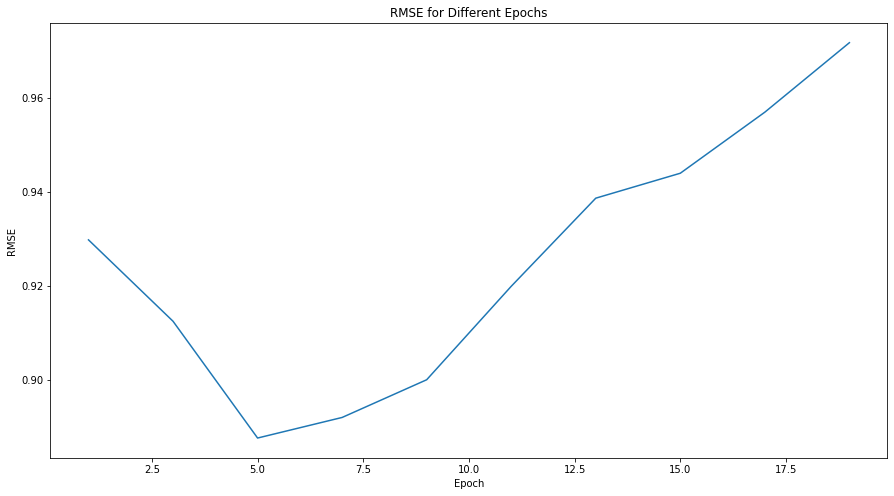

In [8]:
plt.figure(figsize=(15, 8))
plt.plot(epochs, epoch_error)
plt.title('RMSE for Different Epochs')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.show()

In [9]:
lrs = np.linspace(0.0001, 0.1, 20)
lrs_error = np.zeros(len(lrs))

for i in range(len(lrs)):
    model = MF_Interface(
    data=movie_data,
    frac_test_users=0.2,
    n_factors=100,
    train_epochs=5,
    update_epochs=5,
    reg_param=0.005,
    train_lr=lrs[i],
    update_lr=lrs[i],
    init_mean=0,
    init_sd=0.1,
    min_rating=0,
    max_rating=5,
    bound_ratings=True,
    logging=False,
    )
    lrs_error[i] = model.build()

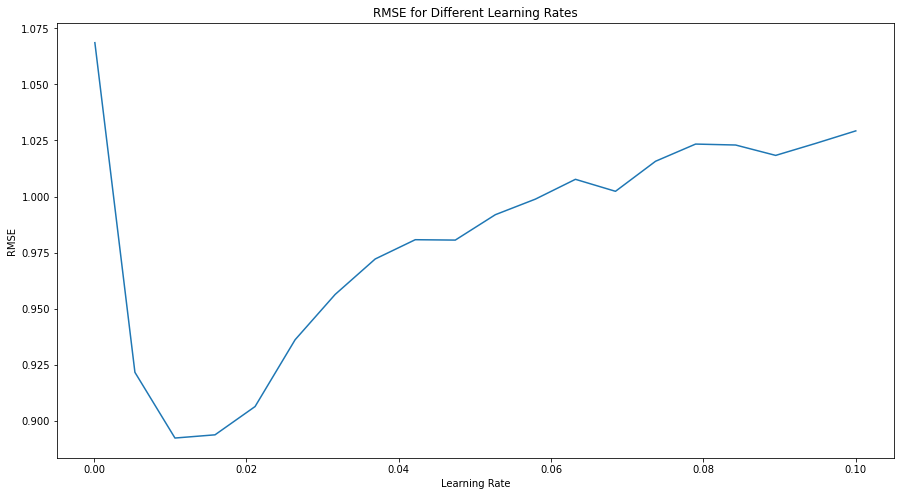

In [10]:
plt.figure(figsize=(15, 8))
plt.plot(lrs, lrs_error)
plt.title('RMSE for Different Learning Rates')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.show()

In [11]:
reg_params = np.linspace(0.0001, 0.1, 20)
reg_params_error = np.zeros(len(reg_params))

for i in range(len(reg_params)):
    model = MF_Interface(
    data=movie_data,
    frac_test_users=0.2,
    n_factors=100,
    train_epochs=5,
    update_epochs=5,
    reg_param=reg_params[i],
    train_lr=0.01,
    update_lr=0.01,
    init_mean=0,
    init_sd=0.1,
    min_rating=0,
    max_rating=5,
    bound_ratings=True,
    logging=False,
    )
    reg_params_error[i] = model.build()

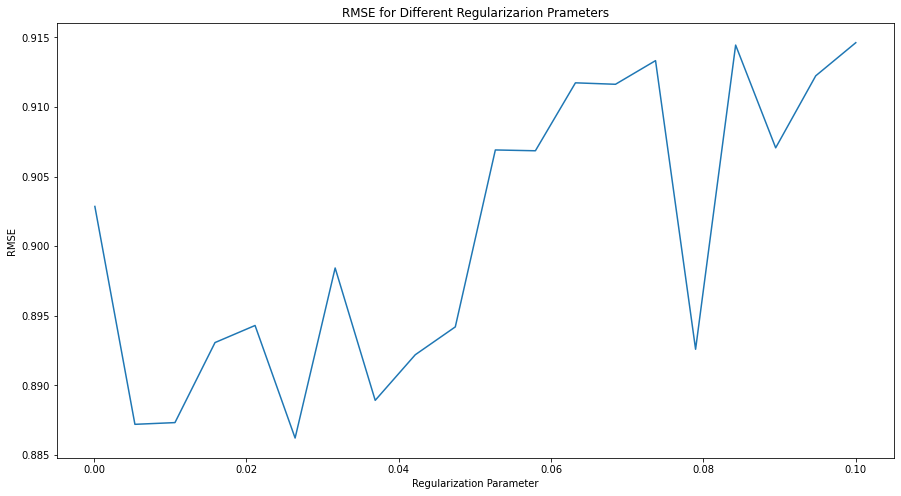

In [12]:
plt.figure(figsize=(15, 8))
plt.plot(reg_params, reg_params_error)
plt.title('RMSE for Different Regularizarion Prameters')
plt.xlabel('Regularization Parameter')
plt.ylabel('RMSE')
plt.show()

In [13]:
n_factors = range(20, 180, 10)
n_factors_error = np.zeros(len(n_factors))

for i in range(len(n_factors)):
    model = MF_Interface(
    data=movie_data,
    frac_test_users=0.2,
    n_factors=n_factors[i],
    train_epochs=5,
    update_epochs=5,
    reg_param=0.02,
    train_lr=0.01,
    update_lr=0.01,
    init_mean=0,
    init_sd=0.1,
    min_rating=0,
    max_rating=5,
    bound_ratings=True,
    logging=False,
    )
    n_factors_error[i] = model.build()

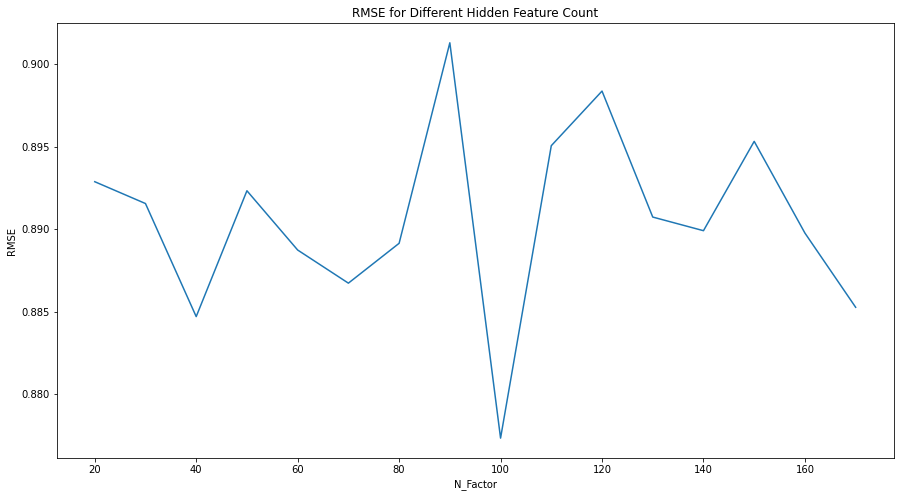

In [14]:
plt.figure(figsize=(15, 8))
plt.plot(n_factors, n_factors_error)
plt.title('RMSE for Different Hidden Feature Count')
plt.xlabel('N_Factor')
plt.ylabel('RMSE')
plt.show()

In [15]:
model = MF_Interface(
    data=movie_data,
    frac_test_users=0.2,
    n_factors=90,
    train_epochs=5,
    update_epochs=5,
    reg_param=0.02,
    train_lr=0.01,
    update_lr=0.01,
    init_mean=0,
    init_sd=0.1,
    min_rating=0,
    max_rating=5,
    bound_ratings=True,
    logging=True,
)

model.build()

recommendation = model.get_recommendation_for_user(user=200)
print(recommendation)

Epoch  1 / 5  -  train_rmse: 0.9055040406270112
Epoch  2 / 5  -  train_rmse: 0.8839813111950147
Epoch  3 / 5  -  train_rmse: 0.864663106785359
Epoch  4 / 5  -  train_rmse: 0.8407285148894157
Epoch  5 / 5  -  train_rmse: 0.8147388194502214
Epoch  1 / 5  -  train_rmse: 0.8792632924977463
Epoch  2 / 5  -  train_rmse: 0.8446066081374418
Epoch  3 / 5  -  train_rmse: 0.8183518367594406
Epoch  4 / 5  -  train_rmse: 0.7950837412234664
Epoch  5 / 5  -  train_rmse: 0.7723205402763874

Test RMSE: 0.8890

Test MAE: 0.6984
      user_id  item_id  rating_pred
866       200     2019     4.806461
3017      200     2905     4.743069
891       200      904     4.678853
1610      200     3030     4.670195
3         200      527     4.666214
561       200     1193     4.665315
163       200      318     4.664987
1040      200     3134     4.638900
1798      200     3091     4.628195
547       200     1148     4.622093
